<a href="https://colab.research.google.com/github/Sushant369/Instance-segmentation/blob/main/Side_portion_of_car_detection_using_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 5.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=e12bd1adc749971bad09c09acc5a053a7da2dcdb7395c78d87af5b69e3d05d70
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 False
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [1]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 595kB/s 
     |████████████████████████████████| 51kB 2.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=fc0e7e2b488443379dd23a6ee885d6b530542f61e9fe0513f6e5335aec2da765
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore
ERROR: fvcore 0.1.3.post20210317 has requirement pyyaml>=5.1, but you'll have pyyaml 3.13 which is incompatible.
ERROR: omegaconf 2.0.6 has requirement PyYAML>=5.1.*, but you'll have pyyaml 3.13 which is incompatible.


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!wget https://github.com/Sushant369/Instance-segmentation/raw/main/train-test-dataset.zip
!unzip train-test-dataset.zip
!ls

 output			       'train-test dataset'
 sample_data		        train-test-dataset.zip
'Test data without labels'      train-test-dataset.zip.1
 Test-data-without-labels.zip


In [ ]:
!ls 'train-test dataset'

test  test.json  train	train.json


In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

directory="/content/train-test dataset/train"

classes = ['side portion of car']
dataset_dicts = []
for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
    json_file = os.path.join(directory, filename)
    with open(json_file) as f:
        img_anns = json.load(f)

    record = {}
    
    filename = os.path.join(directory, img_anns["imagePath"])

filename = os.path.join(directory, img_anns["imagePath"][21:])

print(filename)

/content/train-test dataset/train/27.jpg


In [ ]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_microcontroller_dicts(directory):
    classes = ['side portion of car']
    dataset_dicts = []
    for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"][21:])
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 460
        record["width"] = 460
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "test"]:
    DatasetCatalog.register("car2_" + d, lambda d=d: get_microcontroller_dicts('/content/train-test dataset/' + d))
    MetadataCatalog.get("car2_" + d).set(thing_classes=['side portion of car'])
microcontroller_metadata = MetadataCatalog.get("car2_train")

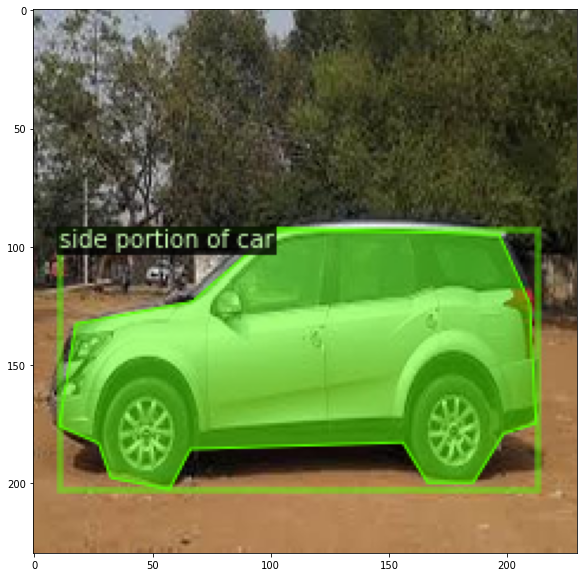

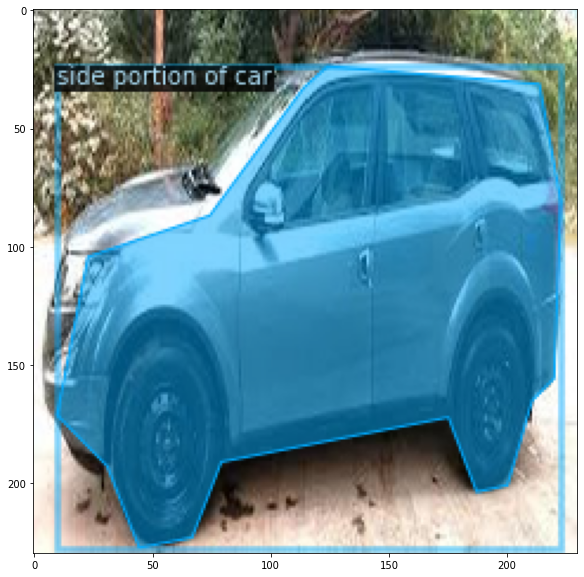

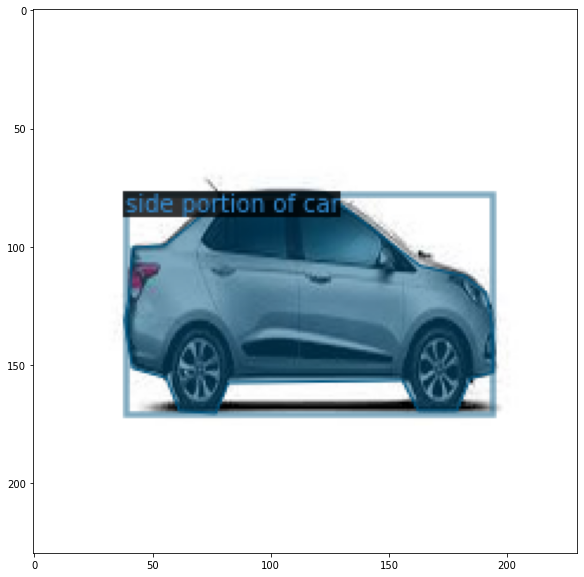

In [ ]:
import random

dataset_dicts = get_microcontroller_dicts("/content/train-test dataset/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car2_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/18 12:54:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[04/18 12:54:50 d2.engine.train_loop]: Starting training from iteration 0
[04/18 12:54:57 d2.utils.events]:  eta: 0:05:24  iter: 19  total_loss: 1.36  loss_cls: 0.535  loss_box_reg: 0.1421  loss_mask: 0.6881  loss_rpn_cls: 0.002997  loss_rpn_loc: 0.003913  time: 0.3345  data_time: 0.0144  lr: 4.9953e-06  max_mem: 1864M
[04/18 12:55:04 d2.utils.events]:  eta: 0:05:18  iter: 39  total_loss: 1.278  loss_cls: 0.4703  loss_box_reg: 0.1488  loss_mask: 0.6586  loss_rpn_cls: 0.003641  loss_rpn_loc: 0.003679  time: 0.3340  data_time: 0.0078  lr: 9.9902e-06  max_mem: 1864M
[04/18 12:55:10 d2.utils.events]:  eta: 0:05:12  iter: 59  total_loss: 1.119  loss_cls: 0.3577  loss_box_reg: 0.1318  loss_mask: 0.6022  loss_rpn_cls: 0.002333  loss_rpn_loc: 0.003522  time: 0.3352  data_time: 0.0061  lr: 1.4985e-05  max_mem: 1864M
[04/18 12:55:17 d2.utils.events]:  eta: 0:05:06  iter: 79  total_loss: 0.9477  loss_cls: 0.2636  loss_box_reg: 0.1269  loss_mask: 0.5354  loss_rpn_cls: 0.002548  loss_rpn_loc: 0.004

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("car2_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_microcontroller_dicts('/content/train-test dataset/test')
for d in random.sample(dataset_dicts, 3):
  print(d["file_name"])   
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  print(outputs)

/content/train-test dataset/test/99.jpg
{'instances': Instances(num_instances=1, image_height=460, image_width=460, fields=[pred_boxes: Boxes(tensor([[ 68.9806, 226.1205, 375.4536, 433.2516]], device='cuda:0')), scores: tensor([0.9987], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')])}
/content/train-test dataset/test/97.jpg
{'instances': Instances(num_instances=1, image_height=460, image_width=460, fields=[pred_boxes: Boxes(tensor([[ 65.6611,  29.9261, 433.8541, 446.4100]], device='cuda:0')), scores: tensor([0.9879], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), 

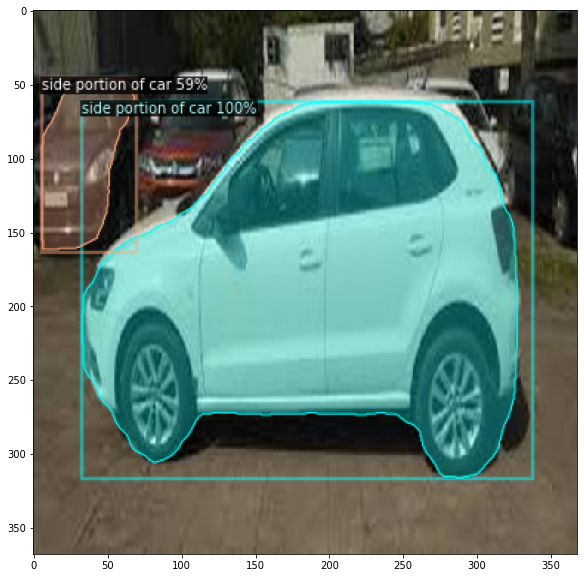

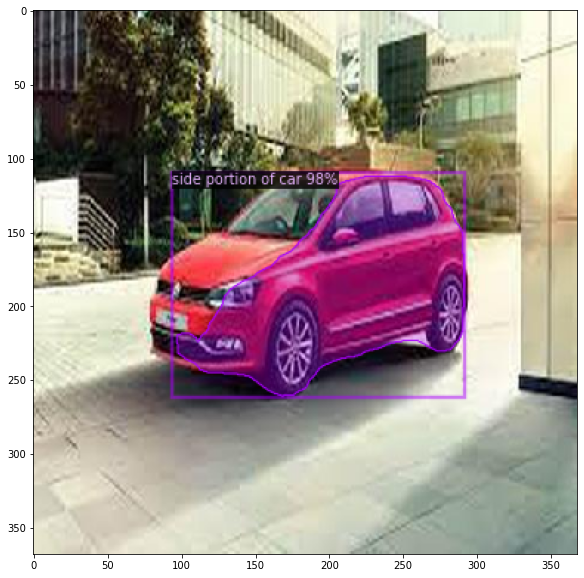

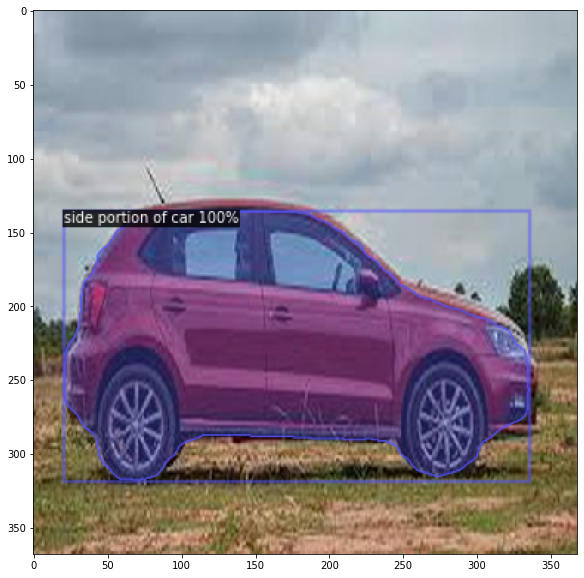

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_microcontroller_dicts('/content/train-test dataset/test')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
!wget https://github.com/Sushant369/Instance-segmentation/raw/main/Test-data-without-labels.zip
!unzip Test-data-without-labels.zip
!ls

--2021-04-18 12:45:34--  https://github.com/Sushant369/Instance-segmentation/raw/main/Test-data-without-labels.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Sushant369/Instance-segmentation/main/Test-data-without-labels.zip [following]
--2021-04-18 12:45:34--  https://raw.githubusercontent.com/Sushant369/Instance-segmentation/main/Test-data-without-labels.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179362 (175K) [application/zip]
Saving to: ‘Test-data-without-labels.zip’

Test-data-without-l 100%[===================>] 175.16K  --.-KB/s    in 0.004s  

2021-04-18 12:45:34 (43.2 MB/s

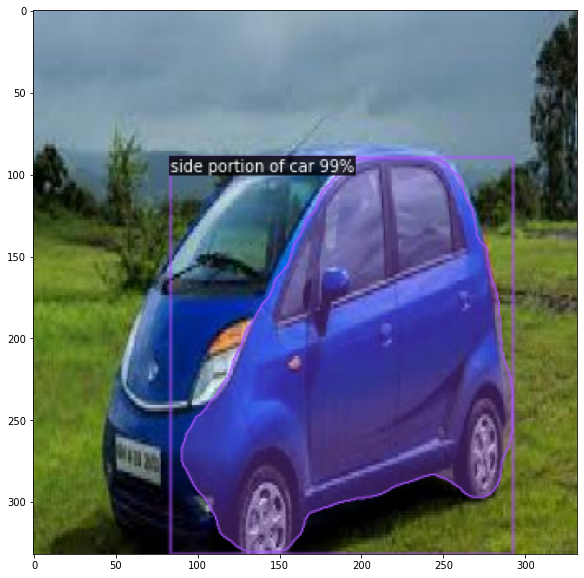

True

In [ ]:
imageName = '/content/Test data without labels/image5.jpg'

from detectron2.utils.visualizer import ColorMode

im = cv2.imread(imageName)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=microcontroller_metadata, 
                scale=0.8, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

cv2.imwrite("/content/detected mask/New.jpg",(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)))



In [ ]:
!pip install pixellib
!pip install tensorflow

In [ ]:
import pixellib
from pixellib.instance import instance_segmentation

segment_image = instance_segmentation()
segment_image.load_model("mask_rcnn_coco.h5")
target_classes = segment_image.select_target_classes(person=True)
segment_image.segmentImage("/content/detected mask/New.jpg", segment_target_classes=target_classes, extract_segmented_objects=True,
save_extracted_objects=True, show_bboxes=True,  output_image_name="/content/detected mask/output.jpg")

OSError: ignored